In [37]:
import sqlite3
from IPython.display import HTML, display

db = 'file:results.db?mode=ro'
con = sqlite3.connect(db, uri=True)

cur = con.cursor()
cur.execute('SELECT * FROM runs ORDER BY date DESC LIMIT 5')

def display_result(cur, data=cur.fetchall()):
    html = "<table>"
    headers = list(map(lambda x: x[0], cur.description))
    
    html += "<thead><tr>" + "".join(["<td>" + h + "</td>" for h in headers]) + "</tr></thead>"
    for row in data:
        html += "<tr>"
        for field in row:
            html += "<td>%s</td>"%(field)
        html += "</tr>"
    html += "</table>"
    display(HTML(html))
display_result(cur)

id,date,hostname,revision,cluster_size,description,flags
27,2021-12-15 14:19:46,i10pc138,b5b598ef21fd5cfd008b23fd778b4a7807de210d,256,,
26,2021-12-15 14:09:18,i10pc138,7f4d1df295ddc0db0ba9f7434ff9686b992c97db,256,,
22,2021-12-14 14:44:51,i10pc138,caae9e9ec5aac44a8b29bab1d8911f246c244264,256,weak scaling,
21,2021-12-14 14:38:53,i10pc138,caae9e9ec5aac44a8b29bab1d8911f246c244264,256,strong scaling,
20,2021-12-09 14:35:11,uc2n183.localdomain,7ed19c50e1da7982f58f2321c57c7f751a46038d,80,,


In [38]:
run_id = 27

<IPython.core.display.Javascript object>


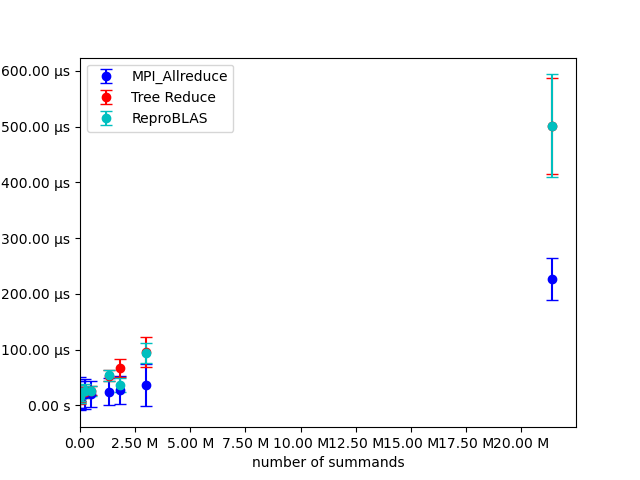

n_summands,datafile,time_ns,stddev,repetitions
460,data/354.binpsllh,16551.2,20452.1,100
767,data/multi100.binpsllh,21162.8,30202.2,100
898,data/prim.binpsllh,19078.0,24658.3,100
1602,data/fusob.binpsllh,18351.4,24734.6,100
239763,data/dna_rokasD4.binpsllh,20230.7,26559.6,100
504850,data/aa_rokasA8.binpsllh,20254.5,22684.5,100
1327505,data/dna_rokasD1.binpsllh,24829.2,24630.6,100
1806035,data/aa_rokasA4.binpsllh,27525.3,25708.4,100
3011099,data/dna_PeteD8.binpsllh,36803.2,37464.5,100
21410970,data/dna_rokasD7.binpsllh,226286.0,38133.0,100


n_summands,datafile,time_ns,stddev,repetitions
460,data/354.binpsllh,17686.1,14647.5,100
767,data/multi100.binpsllh,18995.1,12539.0,100
898,data/prim.binpsllh,22209.4,15174.3,100
1602,data/fusob.binpsllh,18224.5,10668.7,100
239763,data/dna_rokasD4.binpsllh,23659.8,9717.78,100
504850,data/aa_rokasA8.binpsllh,26523.3,7768.42,100
1327505,data/dna_rokasD1.binpsllh,53431.9,10216.9,100
1806035,data/aa_rokasA4.binpsllh,66675.8,15648.7,100
3011099,data/dna_PeteD8.binpsllh,95094.3,26918.7,100
21410970,data/dna_rokasD7.binpsllh,500779.0,86167.6,100


n_summands,datafile,time_ns,stddev,repetitions
460,data/354.binpsllh,16133.3,12542.6,100
767,data/multi100.binpsllh,23615.0,12385.6,100
898,data/prim.binpsllh,20683.2,16587.2,100
1602,data/fusob.binpsllh,18956.3,11599.0,100
239763,data/dna_rokasD4.binpsllh,25703.0,12237.2,100
504850,data/aa_rokasA8.binpsllh,25743.1,8149.04,100
1327505,data/dna_rokasD1.binpsllh,53781.9,9271.09,100
1806035,data/aa_rokasA4.binpsllh,36602.6,12466.7,100
3011099,data/dna_PeteD8.binpsllh,94016.4,17437.4,100
21410970,data/dna_rokasD7.binpsllh,501250.0,92277.4,100


In [52]:
%matplotlib notebook
import sqlite3
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import EngFormatter
from scipy.stats import linregress

# warning: not safe from SQL injection
def fetch_data(mode):
    cur.execute(f"SELECT n_summands, datafile, time_ns, stddev, repetitions FROM results WHERE mode = ?" \
                "AND run_id = ? ORDER BY n_summands",
               (mode, run_id))

def datasets():
    with sqlite3.connect('file:results.db?mode=ro', uri=True) as con:
        cur = con.cursor()

def xye(data):
    x = list(map(lambda x: x[0], data)) # n_summands
    y = list(map(lambda x: x[2] / 1e9, data)) # time_ns
    e = list(map(lambda x: x[3] / 1e9, data)) # stddev
    return x, y, e

settings = {
    "allreduce": {
        "fmt": "bo",
        "label": "MPI_Allreduce",
        "include": True,
    },
    "tree": {
        "fmt": "ro",
        "label": "Tree Reduce",
        "include": True
    },
    "reproblas": {
        "fmt": "co",
        "label": "ReproBLAS",
        "include": True
    },
    "baseline": {
        "fmt": "go",
        "label": "Sequential Baseline",
        "include": False
    }
}
linreg = False

f = plt.figure()
ax = f.subplots(1)
ax.set_ylabel('Accumulate Time')
ax.set_xlabel('number of summands')

formatter0 = EngFormatter(unit='s', places=2)
formatter1 = EngFormatter(places=2)
ax.yaxis.set_major_formatter(formatter0)
ax.xaxis.set_major_formatter(formatter1)

for mode, v in settings.items():
    if not v["include"]:
        continue
        
    fetch_data(mode)
    data = cur.fetchall()
    display(HTML(f"<h4>{mode}</h4>"))
    display_result(cur, data)
    
    ar_x, ar_y, ar_error = xye(data)
    ax.errorbar(ar_x, ar_y, yerr=ar_error, fmt=v["fmt"], label=v["label"], capsize=4.0)
    
    if linreg:
        settings[mode]["linreg"] = linregress(ar_x, ar_y)
        gradient, intercept, r_value, p_value, std_err = settings[mode]["linreg"]
        x1 = np.linspace(min(ar_x), max(ar_x), 50)
        y1 = gradient * x1 + intercept
        plt.plot(x1, y1, v["fmt"][0])

ax.legend(loc='upper left')

ax.set_xlim(left=0)
#ax.set_ylim(bottom=0)

plt.show()
plt.savefig(fname="figure.svg")



In [41]:
def display_table2(data, header = []):
    html = "<table>"
    if len(header) > 0:
        html += "<tr>" + "".join(["<th>" + h + "</th>" for h in header])
    for row in data:
        html += "<tr>"
        for field in row:
            html += "<td>%s</td>"%(field)
        html += "</tr>"
    html += "</table>"
    display(HTML(html))

if linreg:
    header = ["Mode", "Gradient", "R"]
    t = [((mode,
          settings[mode]["linreg"][0],
          settings[mode]["linreg"][2]) if settings[mode]["include"] else []) for mode in settings.keys()]
    display_table2(t, header=header)
    

In [42]:
if linreg:
    slowdown = settings["tree"]["linreg"][0] / settings["allreduce"]["linreg"][0]
    slodown2 = settings["tree"]["linreg"][0] / settings["reproblas"]["linreg"][0]
    display(HTML(f"<h3>Tree Reduce slowdown compared to Allreduce: {round(slowdown,2)}"))
    display(HTML(f"<h3>Tree Reduce slowdown compared to ReproBLAS: {round(slodown2,2)}"))

## Violin plot

<IPython.core.display.Javascript object>


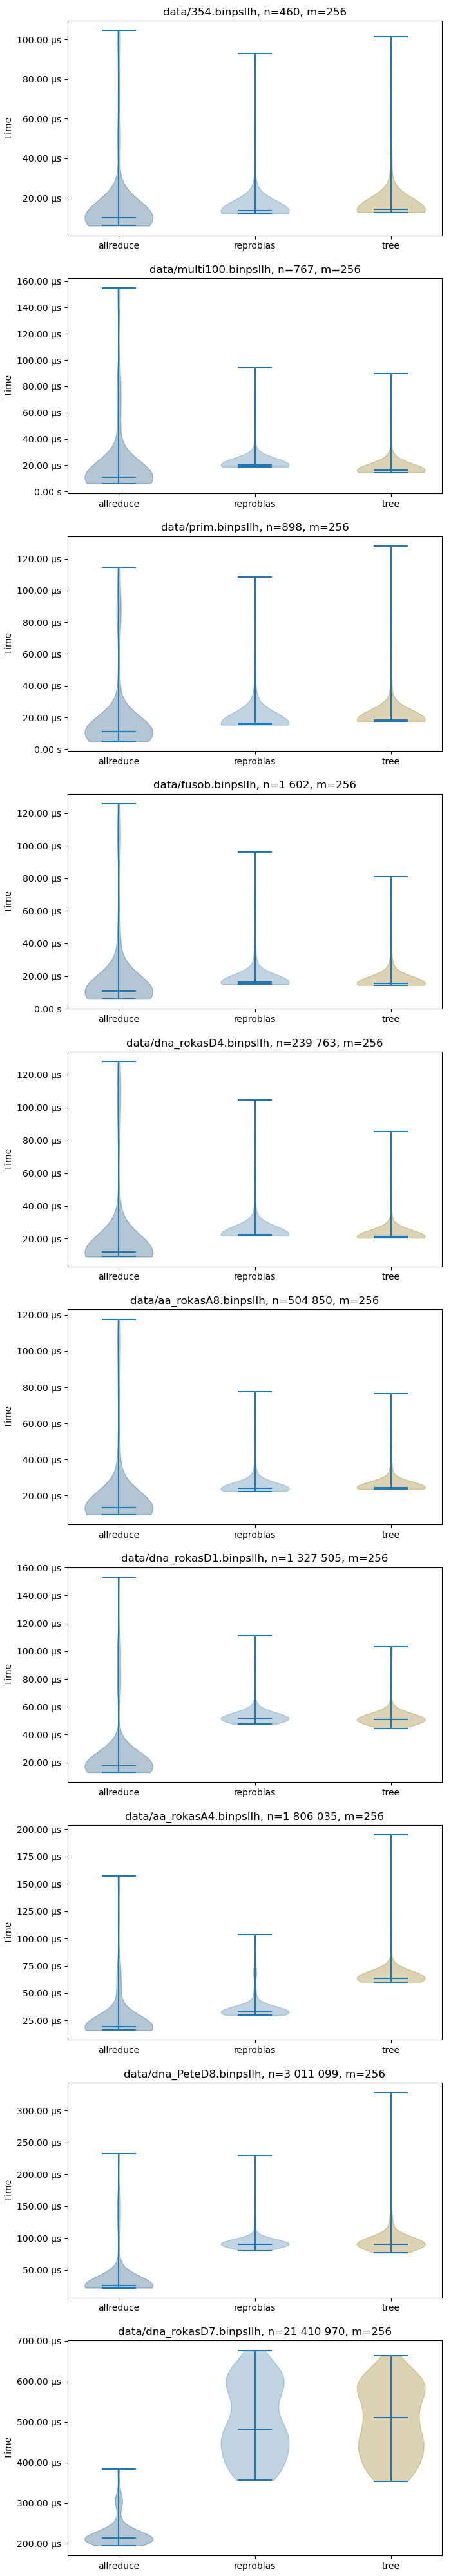

In [76]:
def fetch_durations(run_id):
    plot_data = [[]]
    runs = cur.execute(f"SELECT id, mode, n_summands, datafile, ranks FROM results" \
                    " WHERE run_id = ? ORDER BY n_summands, datafile, mode", (run_id,))
    prev_datafile = None
    
    for result_id, mode, n_summands, datafile, ranks in runs.fetchall():
        if mode == "baseline":
            continue

        if prev_datafile is not None and prev_datafile != datafile:
            plot_data.append([])
        cur.execute("SELECT time_ns / 1e9 FROM durations WHERE result_id = ?", (result_id,))
        
        durations = list(map(lambda x: x[0], cur.fetchall()))
        plot_data[-1].append({
            "mode": mode,
            "datafile": datafile,
            "n": n_summands,
            "m": ranks,
            "durations": durations
        })
        
        
        prev_datafile = datafile
    return plot_data

plot_data = fetch_durations(run_id)
rows = len(plot_data)
cols = max(map(lambda x: len(x), plot_data))
formatter0 = EngFormatter(unit='s', places=2)

f, axs = plt.subplots(nrows=rows, figsize=(7, 4 * rows))

i = 0

colorpalette = ["#034670ff", "#2f779dff", "#887006ff", "#ac360bff"]

for dataset in plot_data:
    ax = axs[i]
    
    mode_durations = list(map(lambda x: x["durations"], dataset))

    ax.set_ylabel("Time")
    ax.yaxis.set_major_formatter(formatter0)
    ax.xaxis.can_zoom = False
    
    ax.get_xaxis().set_visible(True)
    
    # Ticks for each mode
    ax.get_xaxis().set_ticks(range(1, len(dataset)+1))
    ax.get_xaxis().set_ticklabels(list(map(lambda x: x["mode"], dataset)))
    
    n = format(dataset[0]["n"], ",d").replace(",", " ")
    m = dataset[0]["m"]
    filename = dataset[0]["datafile"]
    ax.set_title(f"{filename}, n={n}, m={m}")
    
    violins = ax.violinplot(mode_durations, showmedians=True)
    for body, color in zip(violins["bodies"], colorpalette):
        body.set_color(color)
    
    i += 1
margin_y = 0.08 / rows
plt.subplots_adjust(left=0.15, bottom=0.0 + margin_y, right=0.98, top=1.0 - margin_y)